# Introduction

The intention of the short-term drought forecaster (STDF) is to predict weather and soil moisture for the upcoming year at a fine temporal and spatial scale.

The Climate Prediction Center (CPC) of the National Weather Service (NWS) provides “long-lead” outlooks for temperature and precipitation for 102 regions in the lower 48 of the United States.

![image](images/Screen Shot 2020-05-03 at 6.40.01 PM.png)

These outlooks consist of the probability of whether a region will be hotter or cooler (temperature) and wetter or drier (precipitation) than their 30-year climatological normal (1980-2010) for 1 1-month and 13 3-month outlooks. These outlooks are updated on the 15th of each month and the 1-month outlook is for the nearest upcoming month while the 3-month outlooks consist of 13 total forecasts for the next year. The 3-month outlooks overlap one another, and each individual month is included in up to 3 outlooks. For example, on May 15th, the closest 1-month outlook would be for June, and the nearest 3-month outlook would be for June-July-August. There are subsequent outlooks for July-August-September, August-September-October, and so on for the next 13 month period.

![image](https://www.cpc.ncep.noaa.gov/products/predictions/multi_season/13_seasonal_outlooks/color/page2.gif)

# National Weather Service Forecasts

The NWS uses "probability of exceedance" curves to give the forecast probability that a temperature or precipitation quantity will be exceeded at the location in question, for the forecast period. 

[temperature probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=t)

[precipitation probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=p)

In addition to the probability of exceedance, a ‘point forecast’ is given for the mean forecasted anomaly and the standard deviation (SD) of that anomaly, as well as percentile (%ile) that this mean will exceed the climatological mean (top left corners of the above figures). These probability of exceedance curves are generated for each outlook and region and are the basis for the information we see in the maps above. NWS meteorologists makes these forecasts using a series of models and tools that evaluate historical patterns as well as current global atmospheric and oceanic patterns. Full discussion [here](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/tools.php).

Our intent with the short-term forecaster is to translate the information from the NWS CPC into predictions that are fine-tuned for specific locations, instead of the broad outlooks provided for 102 regions. In addition, we translate these predictions to a finer temporal scale, so we are able to utilize them as the climate driver in in a daily driven, water-balance model, SOILWAT2. SOILWAT2 is a site-specific model, that takes inputs about daily weather, vegetation, and soils (multi-layer), and mechanistically predicts daily soil moisture, a metric used for evaluating likely success of plant germination and survival.

# Downscaling Methods

First, for each set of coordinates, the appropriate region is determined from the map above and the affiliated temperature and precipitation NWS long-lead forecast data are grabbed. Temperature and precipitation data are stored online in tabular form, [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllftd.dat) and [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllfpd.dat).


In [7]:
library(raster)
library(data.table)

# Set coordinates
lat <- 35.1266
lng <- -111.5854

# Determine Region from coordinates and shapefile ------------------------------------------
CD102 <- shapefile(x = 'CD102/CD102.shp')
points <- data.frame(x = lng, y = lat)

coordinates(points) <- ~ x + y 
proj4string(points) <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")

CDRegion <- as.numeric(over(points, CD102)$ID4)

# Read in and subset anomaly data -----------------------------------------------------------
TempMonthlyAnomsWhole <- fread('CurrentAnomalyTempData.csv')
TempMonthlyAnoms <- subset(TempMonthlyAnomsWhole, CD == CDRegion)

PPTMonthlyAnomsWhole <- fread('CurrentAnomalyPPTData.csv')
PPTMonthlyAnoms <- subset(PPTMonthlyAnomsWhole, CD == CDRegion)

print('NWS Temperature Data')
head(TempMonthlyAnoms)
print('NWS Precipitation Data')
head(PPTMonthlyAnoms)

[1] "NWS Temperature Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,70.97,69.98,1.2039,1.35
2020,5,2,97,69.64,68.80,1.0297,1.14
2020,5,3,97,63.00,62.12,1.0835,1.19
2020,5,4,97,53.41,52.51,1.2727,1.40
2020,5,5,97,43.42,42.38,1.3283,1.44
2020,5,6,97,36.88,35.83,1.6065,1.64


[1] "NWS Precipitation Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,PO
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,4.72,4.72,0.3000,0.30,0.49
2020,5,2,97,5.89,5.89,0.4800,0.48,0.61
2020,5,3,97,5.22,5.20,0.5051,0.51,0.68
2020,5,4,97,3.72,3.66,0.2998,0.30,0.40
2020,5,5,97,3.74,3.33,0.2481,0.25,0.28
2020,5,6,97,3.30,3.30,0.2400,0.24,0.27


Next, because the future forecast for each lead is a probability curve we want to create a distribution of potential futures using the NWS data. To accomplish this, we create two sets of "modifiers", one for temperature and one for precipitation, equal to number of potential futures (i.e. n = 30). Because we want to reflect actual conditions, where weather in a year is likely to be consistently dry/wet and consistently cool/hot, and how these effects accumulate, we use a random normal distribution generator function, with a mean of 0 and SD of 1, to generate “modifiers” for both precipitation and temperature and apply the same modifier to one realization of the future.


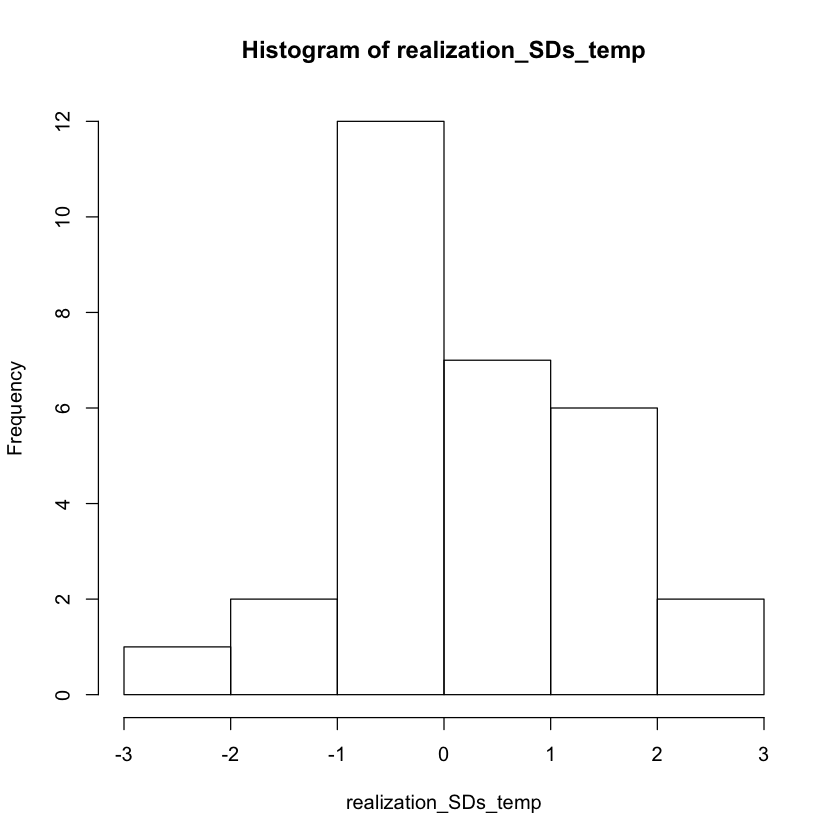

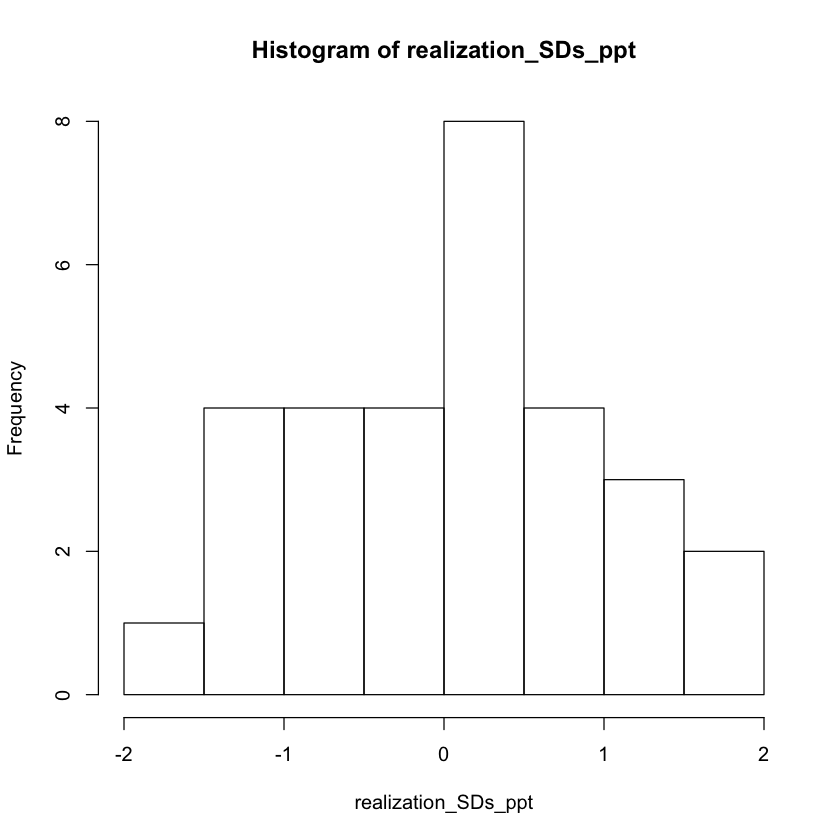

In [9]:
n <- 30
realization_SDs_temp <- rnorm(n)
realization_SDs_ppt <- rnorm(n)
hist(realization_SDs_temp)
hist(realization_SDs_ppt)

To generate predictions for each lead, for both temperature and precipitation, the forecasted standard deviation (forecastedSD) is multiplied by the modifier and added to the forecastedMEAN. Then, an anomaly is calculated by subtracting the predicted value (Prediction_F) from the climatologicalMEAN for temperature, and dividing the predicted value (Prediction_in) by climatalogicalMEAN for precipitation.



In [14]:
nn <- 1
TempMonthlyAnoms$Modifier <-  realization_SDs_temp[nn]
PPTMonthlyAnoms$Modifier <-  realization_SDs_ppt[nn]

# Step 2 - generate an anomaly for each lead and future by
# - A. A sd modifier for each temp and ppt will be selected for each run. This modifier is consistent for each run
# - B. Apply the modifier to generate forecast: forecasted mean + (forecasted sd * modifier)
# - C. Subtract climatological mean from prediction (temp) or divide predicted values by climatalogical mean (ppt)

 # Temp
TempMonthlyAnoms$Prediction_F <-  as.numeric(TempMonthlyAnoms$ForecastedMEAN) +
                    (as.numeric(TempMonthlyAnoms$ForecastedSD) *  TempMonthlyAnoms$Modifier)
TempMonthlyAnoms$Anom_F <- TempMonthlyAnoms$Prediction_F - TempMonthlyAnoms$ClimatologicalMEAN
TempMonthlyAnoms$Anom_C <- TempMonthlyAnoms$Anom_F * (5/9)

# PPT
backT <- 1/PPTMonthlyAnoms$PO
PPTMonthlyAnoms$ForecastedSD_in <- as.numeric(PPTMonthlyAnoms$ForecastedSD) ^ backT #inches
PPTMonthlyAnoms$Prediction_in <- as.numeric(PPTMonthlyAnoms$ForecastedMEAN ^ PPTMonthlyAnoms$PO) +
                    (as.numeric(PPTMonthlyAnoms$ForecastedSD) * PPTMonthlyAnoms$Modifier) 

PPTMonthlyAnoms$Prediction_in <- PPTMonthlyAnoms$Prediction_in ^ backT #inches

PPTMonthlyAnoms$Anom_CF <- PPTMonthlyAnoms$Prediction_in / PPTMonthlyAnoms$ClimatologicalMEAN
PPTMonthlyAnoms$Anom_in <- PPTMonthlyAnoms$Prediction_in - PPTMonthlyAnoms$ClimatologicalMEAN
PPTMonthlyAnoms$Anom_cm <- PPTMonthlyAnoms$Anom_in * 2.54

TempMonthlyAnoms
PPTMonthlyAnoms


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,Modifier,Prediction_F,Anom_F,Anom_C
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,70.97,69.98,1.2039,1.35,-1.156624,69.57754,-0.4024599,-0.2235888
2020,5,2,97,69.64,68.80,1.0297,1.14,-1.156624,68.44902,-0.3509760,-0.1949867
2020,5,3,97,63.00,62.12,1.0835,1.19,-1.156624,61.74680,-0.3732024,-0.2073347
2020,5,4,97,53.41,52.51,1.2727,1.40,-1.156624,51.93796,-0.5720357,-0.3177976
2020,5,5,97,43.42,42.38,1.3283,1.44,-1.156624,41.88366,-0.4963440,-0.2757467
2020,5,6,97,36.88,35.83,1.6065,1.64,-1.156624,35.02188,-0.8081169,-0.4489538
2020,5,7,97,35.00,34.40,1.8439,1.92,-1.156624,32.86730,-1.5326994,-0.8514997
2020,5,8,97,38.35,37.68,1.6754,1.76,-1.156624,36.41219,-1.2678083,-0.7043379
2020,5,9,97,44.15,43.17,1.5151,1.56,-1.156624,42.39760,-0.7724014,-0.4291119


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,PO,Modifier,ForecastedSD_in,Prediction_in,Anom_CF,Anom_in,Anom_cm
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,4.72,4.72,0.3000,0.30,0.49,-0.6127808,0.085684155,3.9291503,0.8324471,-0.7908497,-2.008758
2020,5,2,97,5.89,5.89,0.4800,0.48,0.61,-0.6127808,0.300223478,4.9582179,0.8418027,-0.9317821,-2.366726
2020,5,3,97,5.22,5.20,0.5051,0.51,0.68,-0.6127808,0.366260638,4.4662484,0.8588939,-0.7337516,-1.863729
2020,5,4,97,3.72,3.66,0.2998,0.30,0.40,-0.6127808,0.049212913,2.7905973,0.7624583,-0.8694027,-2.208283
2020,5,5,97,3.74,3.33,0.2481,0.25,0.28,-0.6127808,0.006885773,2.5157594,0.7554833,-0.8142406,-2.068171
2020,5,6,97,3.30,3.30,0.2400,0.24,0.27,-0.6127808,0.005063911,2.1742451,0.6588621,-1.1257549,-2.859418
2020,5,7,97,3.86,3.42,0.2306,0.24,0.25,-0.6127808,0.002827725,2.5234047,0.7378376,-0.8965953,-2.277352
2020,5,8,97,3.86,3.68,0.2296,0.23,0.28,-0.6127808,0.005221036,2.6876733,0.7303460,-0.9923267,-2.520510
2020,5,9,97,3.28,3.27,0.4000,0.40,0.51,-0.6127808,0.165853818,2.4752158,0.7569467,-0.7947842,-2.018752


Since long-lead forecasts are predictions for 3-month long windows, and we want values for individual months, we then take the average of leads that are affiliated with each month. The result is a table of 12 monthly anomalies, one each for both temperature and precipitation.


In [21]:
library(lubridate)
currMonth <- month(Sys.Date())

# How months and leads relate
monthLeads <- data.frame(TempMonthlyAnoms[,'LEAD'])

if(day(Sys.Date()) < 15){
    monthLeads$Month <- monthLeads$LEAD + currMonth - 1 # a lead of one in the current month before the 15th is the current month
} else {
    monthLeads$Month <- monthLeads$LEAD + currMonth # after the 15th the lead of one is the next month
}

# leads
monthLeads$lead1 <- monthLeads$LEAD
monthLeads$lead2 <-  monthLeads$LEAD - 1
monthLeads$lead3 <-  monthLeads$LEAD - 2

monthLeads[monthLeads <= 0] <- NA 
monthLeads$Month <- ifelse(monthLeads$Month > 12, monthLeads$Month - 12, monthLeads$Month)
monthLeads <- monthLeads[1:12,]

print('Months & leads matrix')
monthLeads
# Get monthly means for the correct leads
yearlydat <- data.frame(matrix(nrow = 12, ncol = 2))
names(yearlydat) <- c('tempAnom', 'pptAnom_CF')
yearlydat$MN <- as.numeric(row.names(yearlydat))

for(m in c(yearlydat$MN)){ # for each month, m, in a year, nn

  leads <- c(t(monthLeads[monthLeads$Month == m, 3:5]))

  yearlydat[m, 1] <- mean(TempMonthlyAnoms$Anom_C[leads], na.rm = TRUE) 
  # ppt
  yearlydat[m, 2] <- mean(PPTMonthlyAnoms$Anom_CF[leads], na.rm = TRUE)
}
print('Monthly means of predicted anomalies')
yearlydat

[1] "Months & leads matrix"


,LEAD,Month,lead1,lead2,lead3
,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1,6,1,NA,NA
2,2,7,2,1,NA
3,3,8,3,2,1
4,4,9,4,3,2
5,5,10,5,4,3
6,6,11,6,5,4
7,7,12,7,6,5
8,8,1,8,7,6
9,9,2,9,8,7


[1] "Monthly means of predicted anomalies"


tempAnom,pptAnom_CF,MN
<dbl>,<dbl>,<dbl>
-0.6682638,0.7090153,1
-0.6616498,0.7417101,2
-0.6765387,0.7440106,3
-0.7451857,0.7231756,4
-0.7552936,0.7297906,5
-0.2235888,0.8324471,6
-0.2092878,0.8371249,7
-0.2086367,0.8443812,8
-0.2400396,0.8210516,9


For these broad forecasts to reflect site-specific climatology we apply these regional anomalies to site-specific historical data. Specifically, for a point location (lat, long) historical weather data (1980 – current) is downloaded from [gridMet](http://www.climatologylab.org/gridmet.html), a daily, high-spatial resolution surface meteorological dataset, using the geoknife package. Monthly anomalies are then added (temp) or multipled (ppt) to each day in the relative month.


In [25]:
wdata <- fread('wdata.csv')
print('summary of weather data before anomalies')
summary(wdata)
### Find month in wdata and merge anomalies
wdata$MN <-  month(as.Date(strptime(paste(wdata$Year, wdata$DOY), format="%Y %j"), format="%m-%d-%Y"))
wdata <- merge(wdata, yearlydat)

### Temp ------------------------------------------------------------------------------------ 
wdata$Tmax_C <- wdata$Tmax_C + wdata$tempAnom
wdata$Tmin_C <- wdata$Tmin_C + wdata$tempAnom

### Precip ----------------------------------------------------------------------------
wdata$PPT_cm <- wdata$PPT_cm * wdata$pptAnom_CF

# That's it
wdata <- wdata[,c('Year', 'DOY', 'Tmax_C', 'Tmin_C', 'PPT_cm')]
print('summary of weather data after anomalies')
summary(wdata)

[1] "summary of weather data before anomalies"


     Date                Year           DOY            Tmax_C      
 Length:15341       Min.   :1979   Min.   :  1.0   Min.   :-8.912  
 Class :character   1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.202  
 Mode  :character   Median :2000   Median :183.0   Median :17.783  
                    Mean   :2000   Mean   :183.1   Mean   :17.311  
                    3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:24.928  
                    Max.   :2020   Max.   :366.0   Max.   :44.891  
     Tmin_C             PPT_cm       
 Min.   :-25.3087   Min.   :0.00000  
 1st Qu.: -4.5787   1st Qu.:0.00000  
 Median :  0.7622   Median :0.00000  
 Mean   :  1.2504   Mean   :0.15378  
 3rd Qu.:  7.5302   3rd Qu.:0.06728  
 Max.   : 32.2334   Max.   :9.29819  

[1] "summary of weather data after anomalies"


      Year           DOY            Tmax_C           Tmin_C        
 Min.   :1979   Min.   :  1.0   Min.   :-9.574   Min.   :-25.8342  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.: 9.604   1st Qu.: -5.1867  
 Median :2000   Median :183.0   Median :17.265   Median :  0.2249  
 Mean   :2000   Mean   :183.1   Mean   :16.852   Mean   :  0.7905  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:24.605   3rd Qu.:  7.2407  
 Max.   :2020   Max.   :366.0   Max.   :44.668   Max.   : 32.0099  
     PPT_cm       
 Min.   :0.00000  
 1st Qu.:0.00000  
 Median :0.00000  
 Mean   :0.11846  
 3rd Qu.:0.05229  
 Max.   :6.59256  

Next, three-year long SOILWAT2 simulations are run using this data. First year is observed data for spin up , second year is part observed and the future, third year is the rest of the future and then dummy data after today's date + 12 months. The anomalies are applied to each year in the historical record for each future (i.e. 30 years). EAch year is run individually so therre is proper spin up and not confound the accumulation of certain conditions and represent the range of possible conditions at the site. This entire process is repeated 30 times, resulting in 900 years.

# Downscaling Results




In [4]:
# Read in Example Data all at once to inspect downstream
library(data.table)
library(ggplot2)
library(lubridate)

# Read in data
HistDataNormMean <- fread('ExampleData/HistDataNormMean.csv')
AnomRunStats <- fread('ExampleData/AnomRunStats.csv')
AnomSave <- fread('ExampleData/AnomSave.csv')
TempAnoms <- fread('ExampleData/TempMonthlyAnomsAll.csv')
PPTAnoms <- fread('ExampleData/PPTMonthlyAnomsAll.csv')


[1] "Density plots of predicted LEAD Anomalies"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



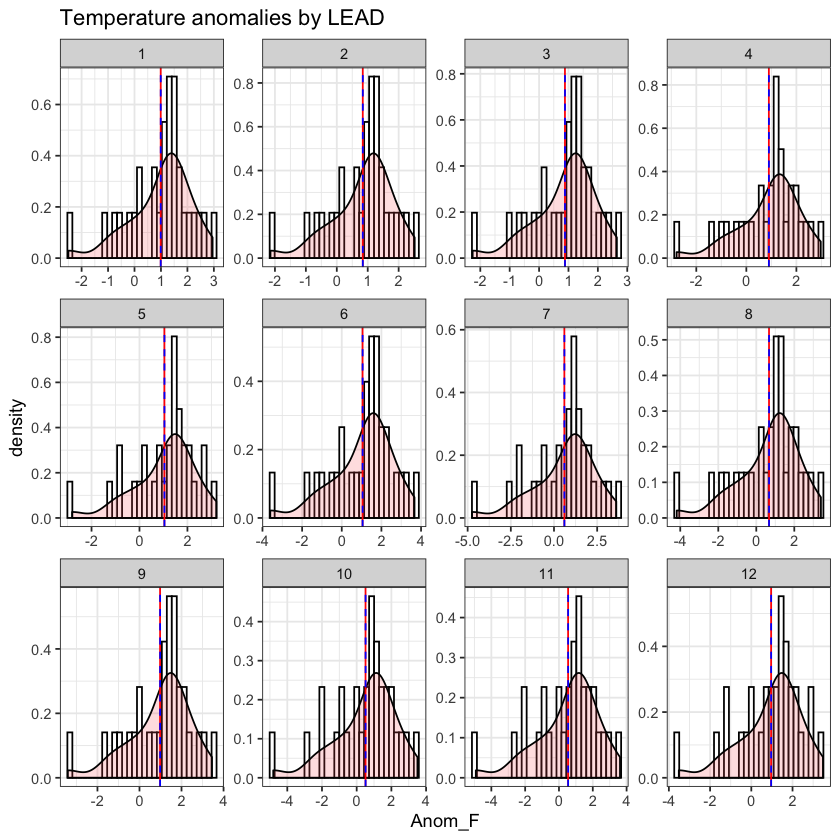

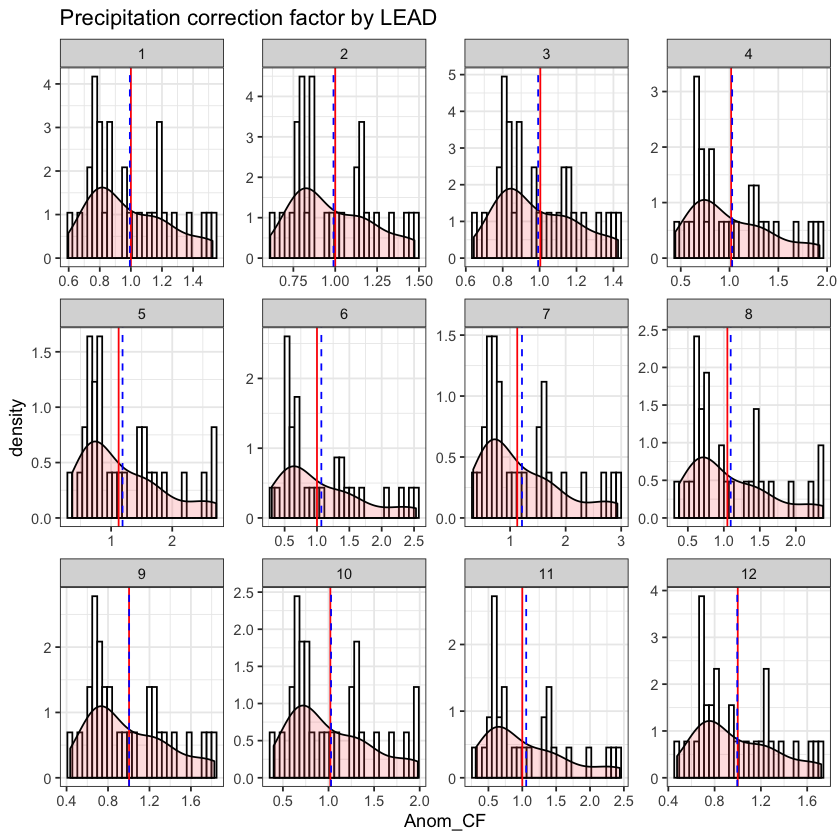

In [5]:
print('Density plots of predicted LEAD Anomalies')
# the anomaly from NWS is the thick red line. 
# the mean of the realization is the dashed blue line
# 30 Future realizations as denisty/histograms

TempAnoms$NWSAnom <- TempAnoms$ForecastedMEAN - TempAnoms$ClimatologicalMEAN
OurAnoms <- setDT(TempAnoms)[,.(Anom_F = mean(Anom_F)), .(LEAD)]

ggplot(TempAnoms, aes(Anom_F)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="#FF6666") +
  facet_wrap(~LEAD, scales = 'free') +
  labs(title = 'Temperature anomalies by LEAD') + 
  geom_vline(aes(xintercept = NWSAnom), color = 'red')+
  geom_vline(data = OurAnoms, aes(xintercept = Anom_F), color = 'blue', linetype = 'dashed')+
  
  theme_bw()

# ---------------------------------------------------------------------
PPTAnoms$NWSAnom <- PPTAnoms$ForecastedMEAN/ PPTAnoms$ClimatologicalMEAN
OurAnoms <- setDT(PPTAnoms)[,.(Anom_CF = mean(Anom_CF)), .(LEAD)]

ggplot(PPTAnoms, aes(Anom_CF)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white") +
  geom_density(alpha=.2, fill="#FF6666") +
  facet_wrap(~LEAD, scales = 'free') +
  geom_vline(aes(xintercept = NWSAnom), color = 'red') +
  geom_vline(data = OurAnoms, aes(xintercept = Anom_CF), color = 'blue', linetype = 'dashed')+
  labs(title = 'Precipitation correction factor by LEAD') +
  theme_bw()


[1] "Density plots of monthly anomalies used in SOILWAT2"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


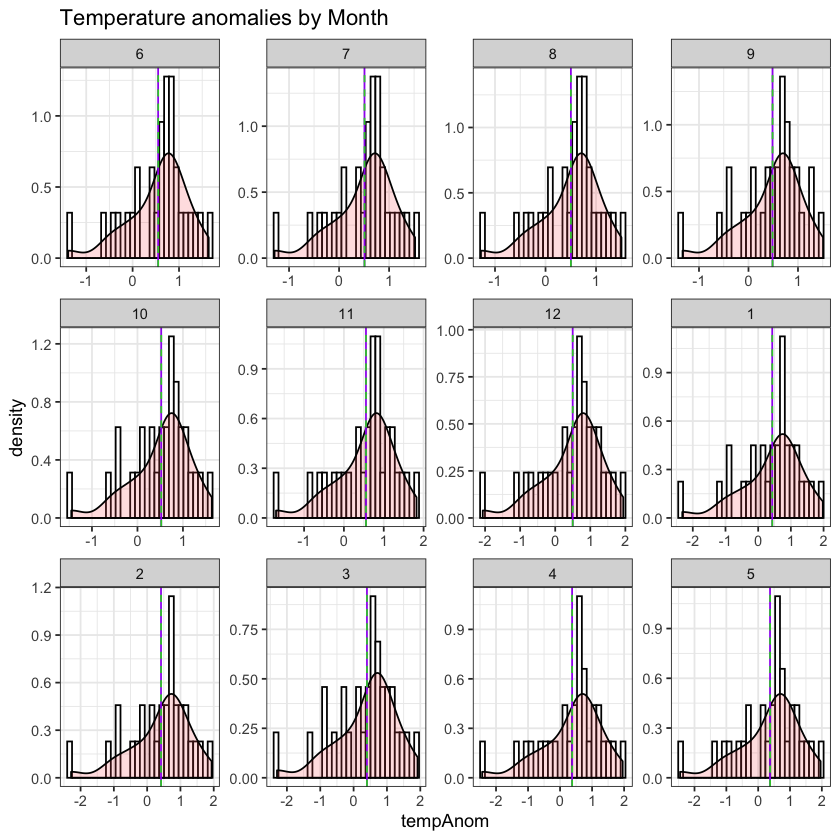

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



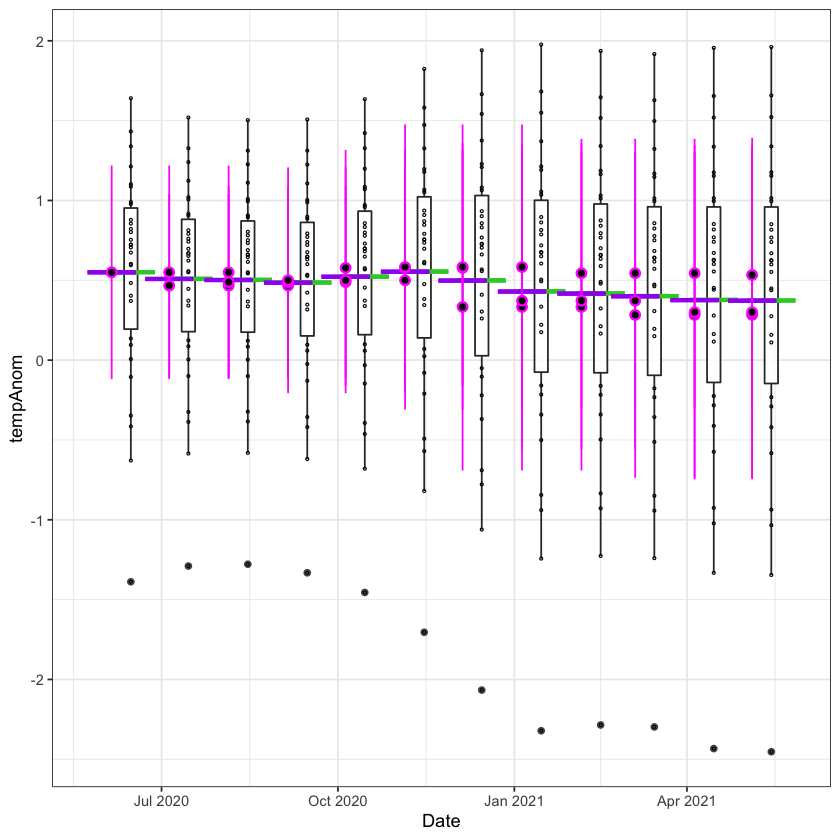

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


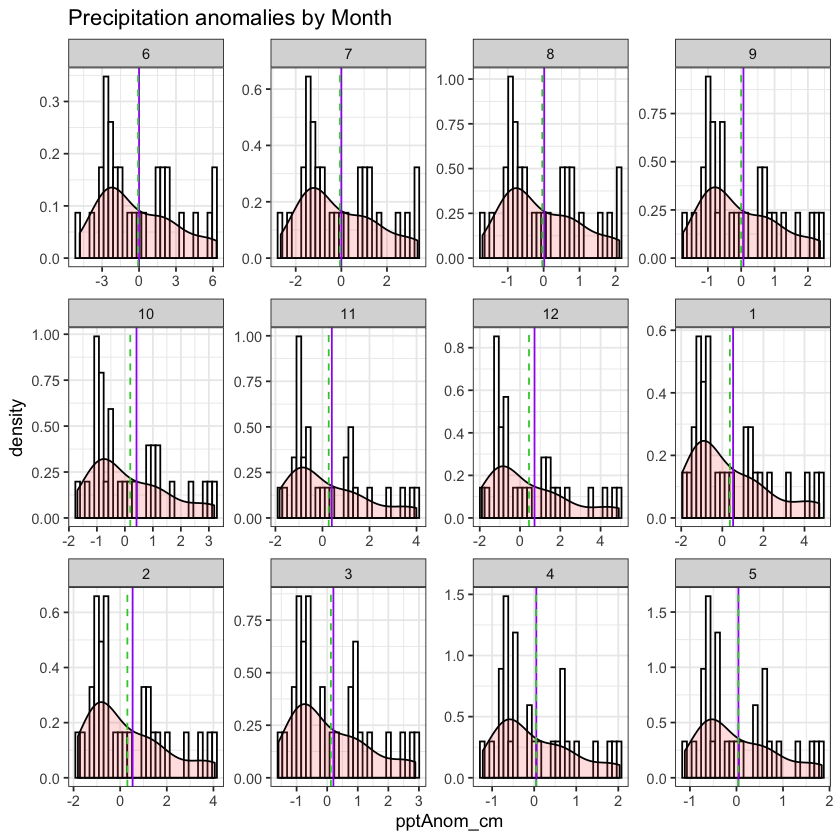

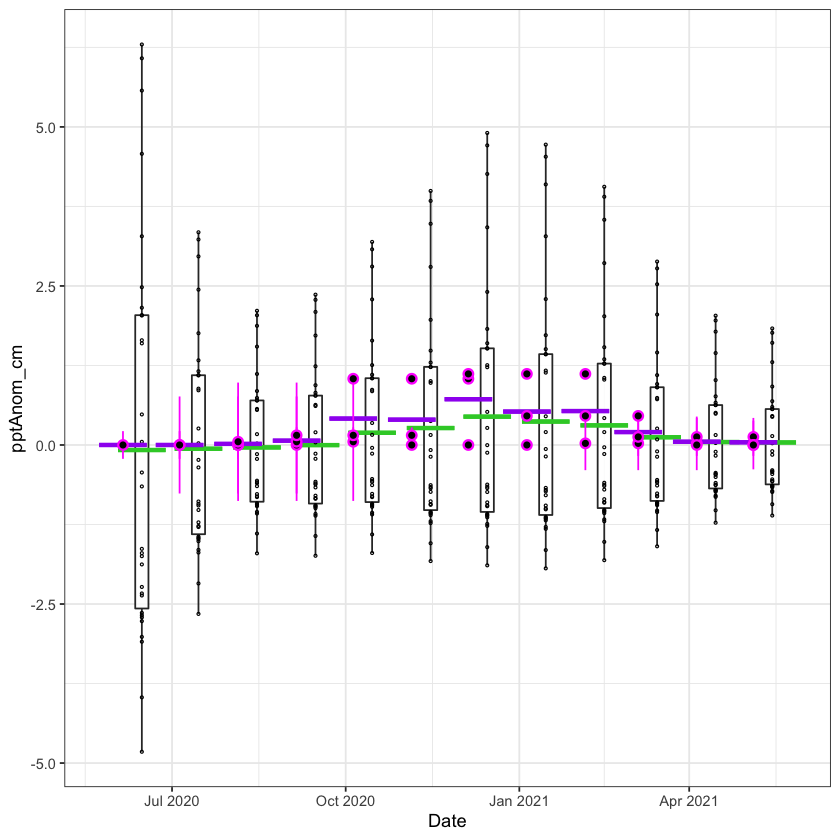

In [6]:
# Plot comparing monthly means to LEADS
print('Density plots of monthly anomalies used in SOILWAT2')
source('figureCode/presentationFigs/FigureDataPrep.R')
AnomSave2 <- AnomSave
AnomSave2$Month <- factor(AnomSave2$Month, levels = c(6:12, 1:5))

# ----- 30 sets of monthly anomalies vs. affiliated NWS data
# temperature
NWSMeans <- setDT(NWSAnomsAll1)[,.(meanForecastDiff = mean(ForecastDiff)), .(m)]
names(NWSMeans)[1] <- 'Month'
generatedMean <- setDT(AnomSave2)[,.(meanGenAnom = mean(tempAnom)), .(Month)]
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

ggplot(AnomSave2, aes(tempAnom)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="#FF6666") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Temperature anomalies by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw()

ggplot() + 
  geom_boxplot(data = AnomSave2, aes(Date, tempAnom, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = AnomSave2, aes(Date, tempAnom, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = AnomSave2, aes(Date, tempAnom, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll1, aes(Date, ForecastDiff,
                                           ymin = ForecastDiff - ForecastedSD,
                                           ymax = ForecastDiff + ForecastedSD), shape = 21, fill = 'black', color = 'magenta') +
   theme_bw()
  

  
# precip

NWSMeans <- setDT(NWSAnomsAll2)[,.(meanForecastDiff = mean(ForecastDiff)), .(m)]
names(NWSMeans)[1] <- 'Month'
generatedMean <- setDT(AnomSave2)[,.(meanGenAnom = mean(pptAnom_cm)), .(Month)]
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

# hists
ggplot(AnomSave2, aes(pptAnom_cm)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="#FF6666") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Precipitation anomalies by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw()

# boxplots
ggplot() + 
  geom_boxplot(data = AnomSave2, aes(Date, pptAnom_cm, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = AnomSave2, aes(Date, pptAnom_cm, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = AnomSave2, aes(Date, pptAnom_cm, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll2, aes(Date, ForecastDiff,
                                           ymin = ForecastDiff - ForecastedSD_cm,
                                           ymax = ForecastDiff + ForecastedSD_cm), shape = 21, fill = 'black', color = 'magenta') + 
  theme_bw()



Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 365 rows containing missing values (geom_path).”


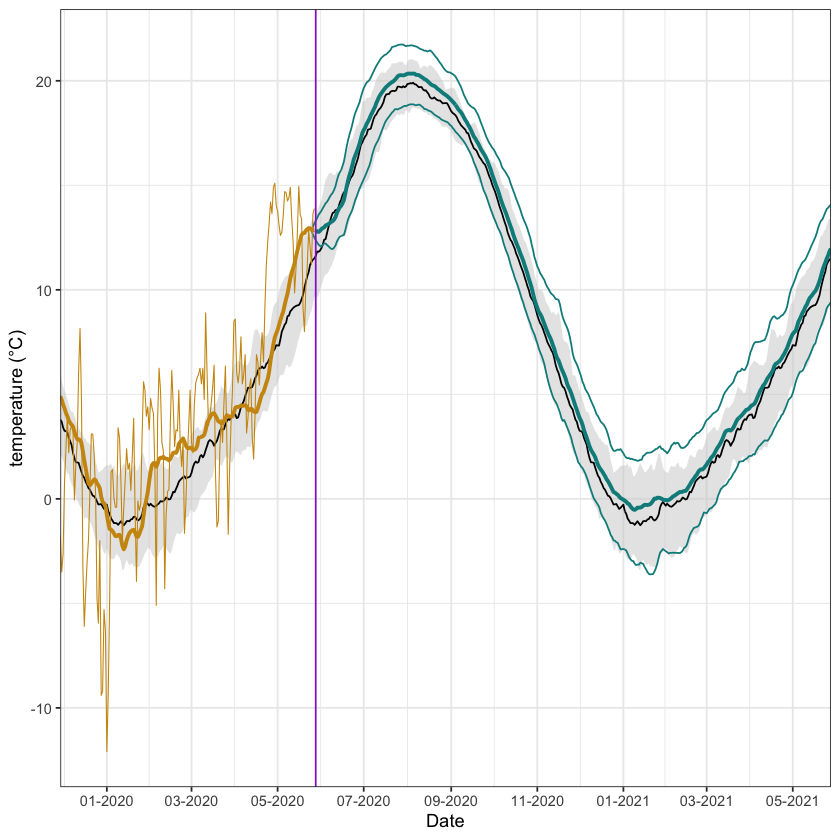

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


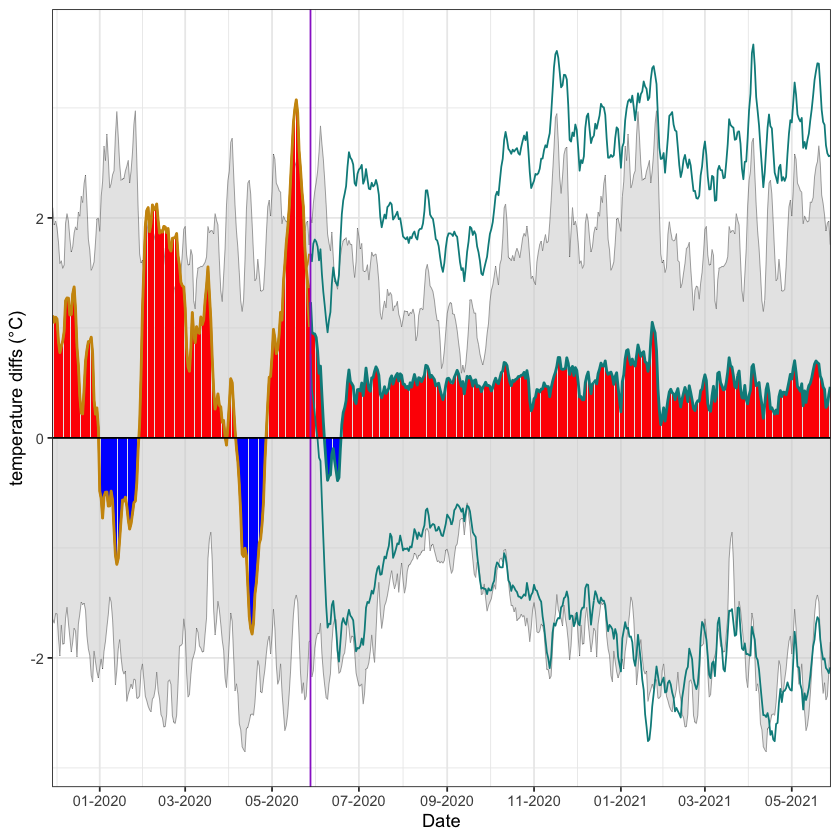

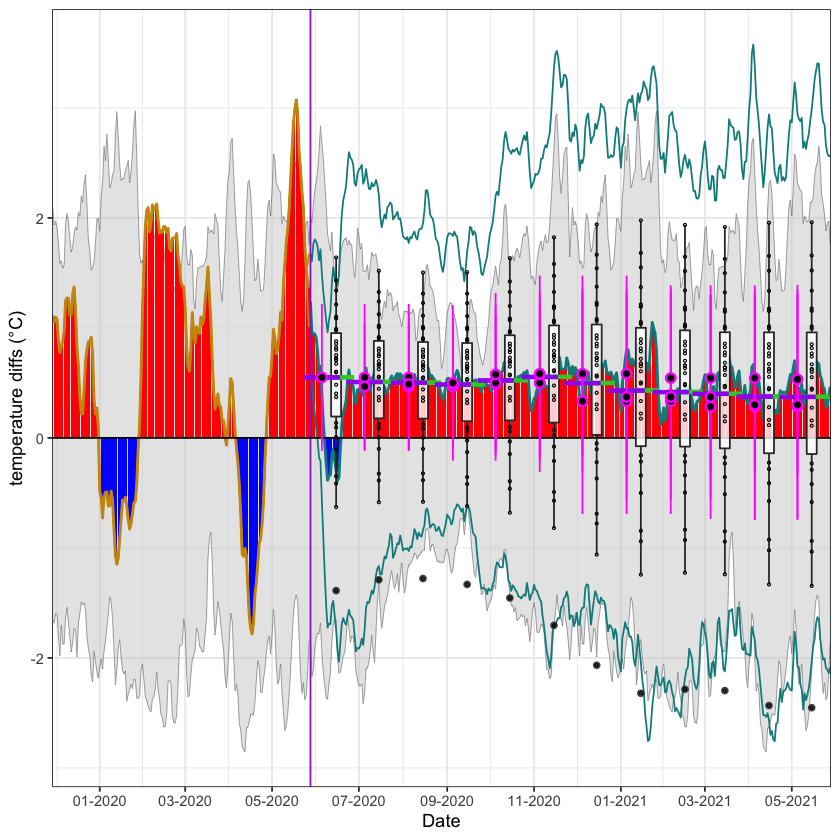

In [8]:
####### This is a lot of code!
source('figureCode/presentationFigs/Temperature.R')


Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 365 rows containing missing values (position_stack).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”


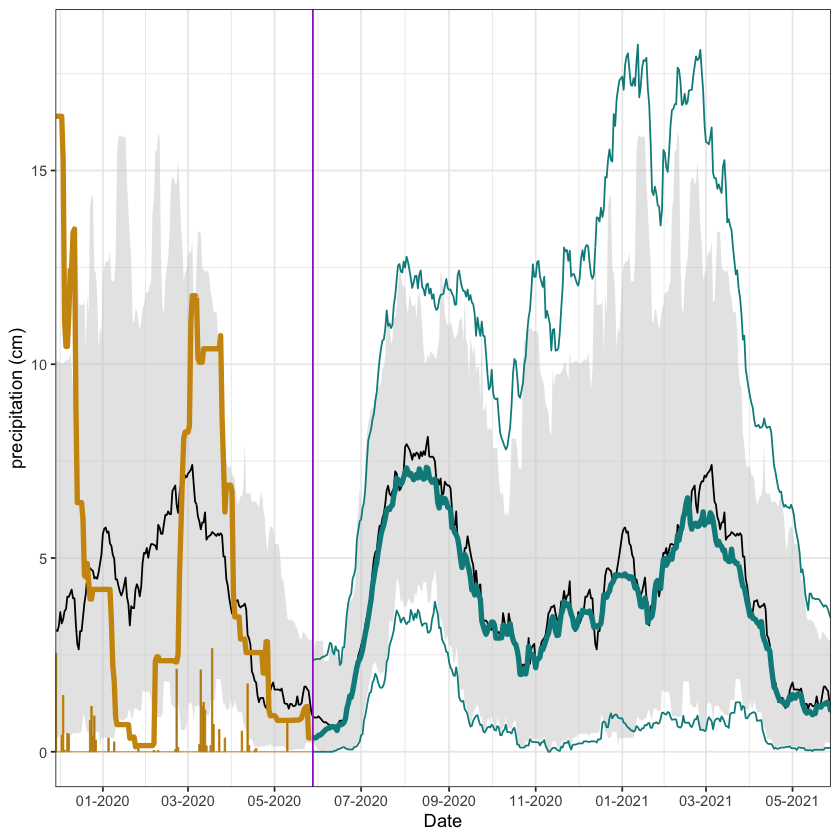

Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning messag

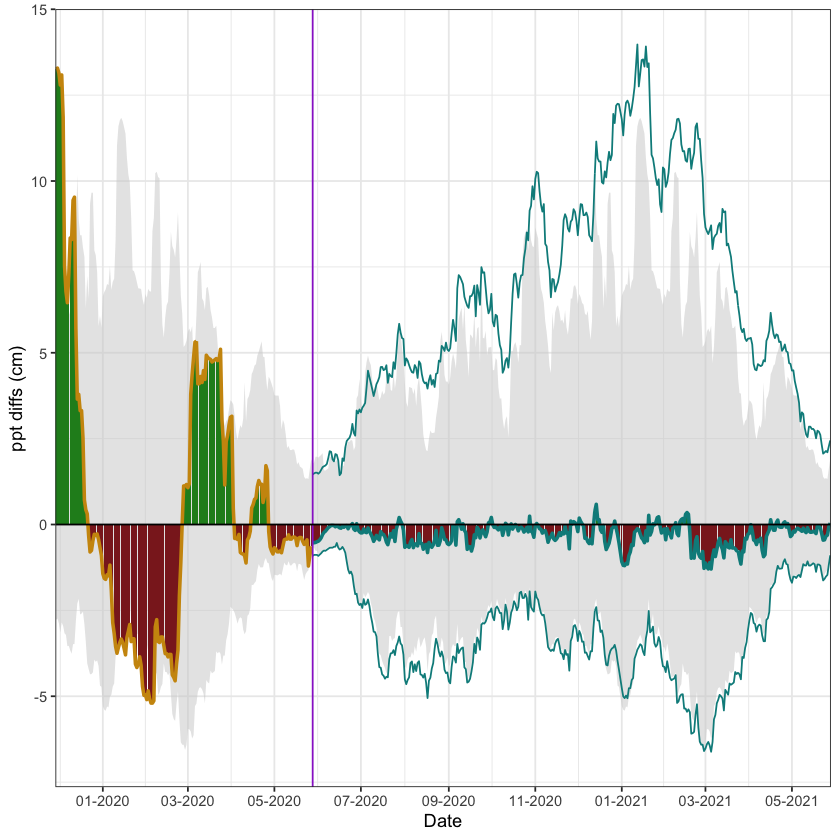

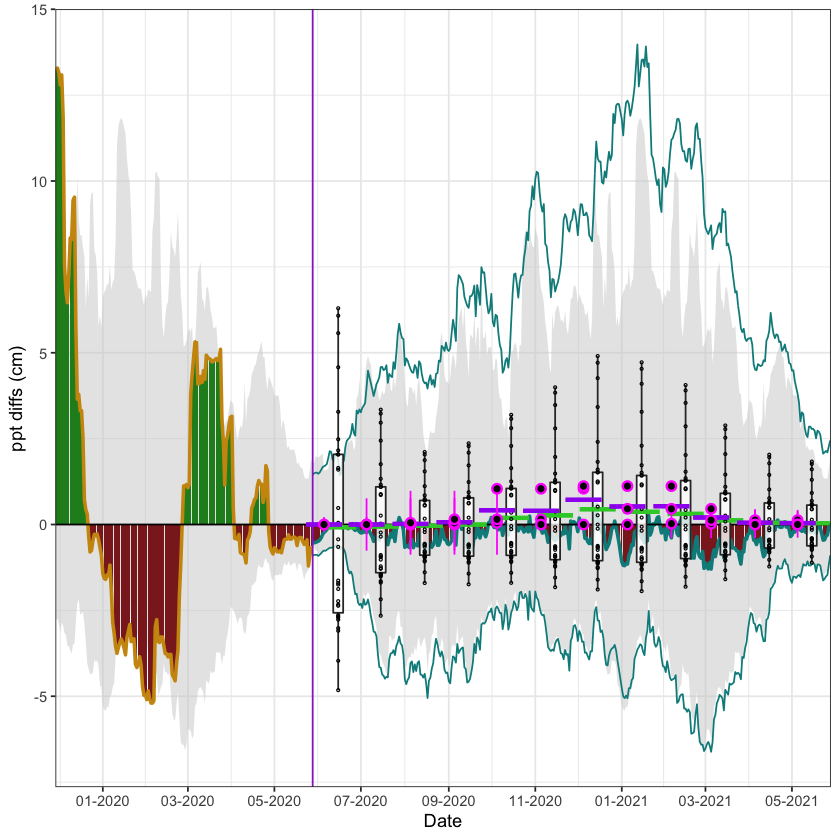

In [9]:
source('figureCode/presentationFigs/Precipitation.R')
